In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# Create engine.#Use SQLAlchemy create_engine to connect to your sqlite database. 
hawaii_path = "Resources/hawaii.sqlite"

engine_hawaii = create_engine(f"sqlite:///{hawaii_path}")
#engine_hawaii = create_engine(f"sqlite:///Resources/hawaii.sqlite")

hawaii = pd.read_sql("SELECT * FROM measurement", engine_hawaii)
hawaii.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
hawaii = pd.read_sql("SELECT * FROM station", engine_hawaii)
hawaii.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [11]:
#inspector = inspect(engine_hawaii)
#inspector.get_table_names()

In [12]:
# reflect an existing database into a new model
# reflect the tables
#Use SQLAlchemy automap_base() to reflect your tables into classes...

In [13]:
# Reflect an existing database into ORM class
Base = automap_base()
Base.prepare(engine_hawaii, reflect=True)

# used SQLite engine and reflected my database into a new model

In [14]:
# We can view all of the classes that automap found

In [15]:
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table (those classes called Station and Measurement) 

In [17]:
measurement = Base.classes.measurement

In [18]:
station = Base.classes.station

In [ ]:
# Create our session (link) from Python to the DB

In [19]:
# The ORM’s “handle” to the database is the Session.
from sqlalchemy.orm import Session
session = Session(engine_hawaii)

In [21]:
inspector = inspect(engine_hawaii)
inspector.get_table_names()

['measurement', 'station']

In [22]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
#columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [23]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores D3 A


prcp_results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > '2016-08-23').\
    order_by(measurement.date).all()


In [25]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date sort_valuesprcp_results = prcp_results
prcp_df = pd.DataFrame(prcp_results)
prcp_df.set_index(["date"],inplace=True, drop=True)
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


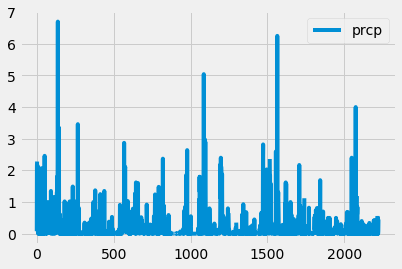

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data - create bar chart
#(2-3 lines max)

prcp_df = pd.DataFrame(prcp_results)
prcp_df.plot()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
# Design a query to show how many stations are available in this dataset?
#count
len(session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all())

9

In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#max, order

session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Query for the date and precipitation (max, mean, min) 
# for all dates in the year
# Sort the result by date

session.query(func.max(measurement.tobs),
              func.avg(measurement.tobs),
              func.min(measurement.tobs)).filter(measurement.station == "USC00519281").all()

[(85.0, 71.66378066378067, 54.0)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


prcp_results = session.query(measurement.tobs).\
    filter(measurement.date > '2016-08-23').\
    filter(measurement.station == "USC00519281").\
    order_by(measurement.date).all()
prcp_df = pd.DataFrame(prcp_results)
prcp_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


Text(0, 0.5, '# Observations')

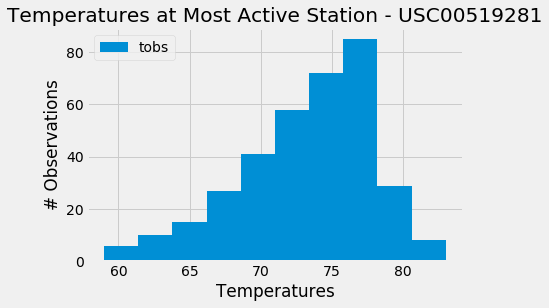

In [32]:
prcp_df.plot.hist()
plt.title("Temperatures at Most Active Station - USC00519281")
plt.xlabel('Temperatures')
plt.ylabel('# Observations')